In [ ]:
!pip install matplotlib==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from collections import defaultdict

from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [ ]:
df = pd.read_csv(data_path, nrows = 50000)
df["Text"]= df['Text'].apply(pre_process)
df['labels'] = df['VOC_CONCEPT'].apply(lambda x: x.split('|'))
df.head()

,CELEX,VOC_CONCEPT,Text,labels
0,21972A0722(03),Switzerland|trading operation|customs duties|t...,a agreement between the european economic comm...,"[Switzerland, trading operation, customs dutie..."
1,21980D1231(03),Greece|tariff policy|agreement (EU)|accession ...,d decision no of the eec iceland joint committ...,"[Greece, tariff policy, agreement (EU), access..."
2,21981A0710(02),Hungary|trade agreement (EU)|goatmeat|sheepmea...,a exchange of letters between the european eco...,"[Hungary, trade agreement (EU), goatmeat, shee..."
3,21986A1115(03),trade agreement|Portugal|protocol to an agreem...,en official journal of the european communitie...,"[trade agreement, Portugal, protocol to an agr..."
4,21987A0720(02),protocol to an agreement|customs harmonisation...,en official journal of the european communitie...,"[protocol to an agreement, customs harmonisati..."


In [ ]:
print(f"There are {len(df)} rows in the dataset.")

There are 50000 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(df["Text"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Text.")

There are 1163 duplicate Text.


In [ ]:
df = df[~df["Text"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 48837 rows in the deduplicated dataset.


In [ ]:
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_dicts[label]+=1
labels = pd.Series(label_dicts).to_frame()
labels.rename(columns={0:'cnt'}, inplace = True)
labels ['category'] = pd.cut(labels['cnt'], bins = [0, 1, 10, 50, 100, 500, 1000, 2500], labels = ['1label','10labels', '50labels', '100labels', '500labels', '1000labels', '2500labels'])
labels.sort_values(by='cnt')

,cnt,category
natural fibre,1,1label
European Systemic Risk Board,1,1label
industrial credit,1,1label
Hovedstaden (region),1,1label
ice,1,1label
...,...,...
control of State aid,1741,2500labels
European Commission,1850,2500labels
State aid,2232,2500labels
merger control,2446,2500labels


In [ ]:
labels.groupby('category')['category'].count().to_frame()

,category
category,
1label,674
10labels,2157
50labels,1870
100labels,501
500labels,620
1000labels,62
2500labels,25


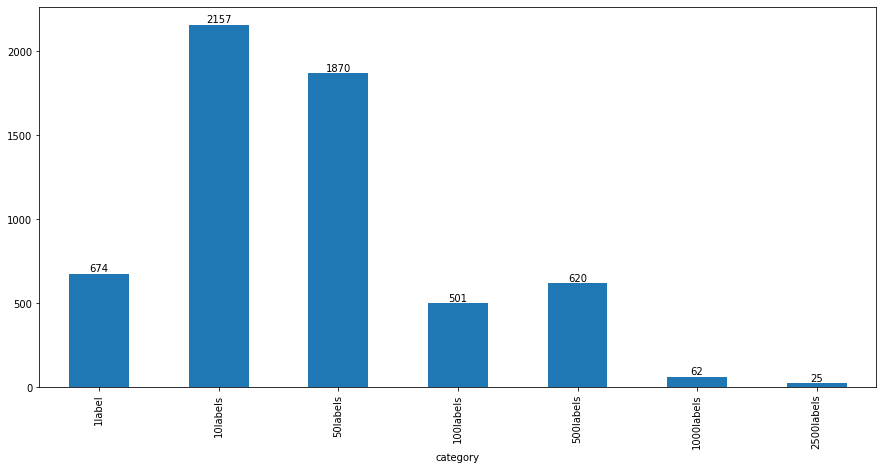

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax = labels.groupby('category')['category'].count().plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
filtered_labels = set(labels[(labels['category']== '2500labels') | (labels['category']== '1000labels')].index)
filtered_labels

{'Belgium',
 'China',
 'EU Member State',
 'EU aid',
 'EU financing',
 'EU programme',
 'EU trade mark',
 'European Commission',
 'European Economic Area',
 'European official',
 'European trademark',
 'France',
 'Germany',
 'Greece',
 'Italy',
 'Netherlands',
 'Portugal',
 'Spain',
 'State aid',
 'United Kingdom',
 'VAT',
 'accession to the European Union',
 'action for annulment of an EC decision',
 'action for failure to fulfil an obligation',
 'action programme',
 'agreement (EU)',
 'agricultural product',
 'aid to agriculture',
 'air transport',
 'anti-dumping duty',
 'application of EU law',
 'approximation of laws',
 'award of contract',
 'catch quota',
 'chemical product',
 'citrus fruit',
 'common organisation of markets',
 'consumer information',
 'consumer protection',
 'control of State aid',
 'designation of origin',
 'disclosure of information',
 'economic concentration',
 'economic sanctions',
 'environmental protection',
 'equal treatment',
 'exchange of information',
 

In [ ]:
df['check_labels'] = df['labels'].apply(lambda x: any(label in filtered_labels for label in x))
print(np.unique(df['check_labels'], return_counts = True))
df = df[df['check_labels']]
df.head()

(array([False,  True]), array([11592, 37245]))


,CELEX,VOC_CONCEPT,Text,labels,check_labels
1,21980D1231(03),Greece|tariff policy|agreement (EU)|accession ...,d decision no of the eec iceland joint committ...,"[Greece, tariff policy, agreement (EU), access...",True
3,21986A1115(03),trade agreement|Portugal|protocol to an agreem...,en official journal of the european communitie...,"[trade agreement, Portugal, protocol to an agr...",True
4,21987A0720(02),protocol to an agreement|customs harmonisation...,en official journal of the european communitie...,"[protocol to an agreement, customs harmonisati...",True
5,21987D0411(04),certificate of origin|joint committee (EU)|cus...,d decision no of the eec sweden joint committe...,"[certificate of origin, joint committee (EU), ...",True
6,21987D0411(05),customs formalities|administrative cooperation...,d decision no of the eec switzerland joint com...,"[customs formalities, administrative cooperati...",True


In [ ]:
df['labels'] = df['labels'].apply(lambda x: [label for label in x if label in filtered_labels])
df.reset_index(drop=True, inplace = True)
df

,CELEX,VOC_CONCEPT,Text,labels,check_labels
0,21980D1231(03),Greece|tariff policy|agreement (EU)|accession ...,d decision no of the eec iceland joint committ...,"[Greece, agreement (EU), accession to the Euro...",True
1,21986A1115(03),trade agreement|Portugal|protocol to an agreem...,en official journal of the european communitie...,"[Portugal, protocol to an agreement, accession...",True
2,21987A0720(02),protocol to an agreement|customs harmonisation...,en official journal of the european communitie...,"[protocol to an agreement, revision of an agre...",True
3,21987D0411(04),certificate of origin|joint committee (EU)|cus...,d decision no of the eec sweden joint committe...,[originating product],True
4,21987D0411(05),customs formalities|administrative cooperation...,d decision no of the eec switzerland joint com...,[originating product],True
...,...,...,...,...,...
37240,32003B0407,implementation of the budget|European Agency f...,b ec european parliament decision of april on ...,[financial year],True
37241,32003B0754,general budget (EU)|amending budget|financial ...,b final adoption of amending budget no of the ...,"[general budget (EU), financial year]",True
37242,32003C1023(01),fraud|EFTA countries|money laundering|European...,c joint declaration by the contracting parties...,"[European Economic Area, agreement (EU)]",True
37243,32003D0151,animal breeding|cattle|embryo and foetus|healt...,d ec commission decision of march amending dec...,"[health control, veterinary inspection, third ...",True


In [ ]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df[['Text', 'labels']],
    test_size=test_split,
)

In [ ]:
# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 29796
Number of rows in validation set: 3724
Number of rows in test set: 3725


In [ ]:
terms = tf.ragged.constant(train_df["labels"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

In [ ]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'economic concentration', 'merger control', 'State aid', 'European Commission', 'control of State aid', 'originating product', 'trademark law', 'exchange of information', 'EU Member State', 'import', 'Italy', 'import (EU)', 'Spain', 'EU programme', 'Germany', 'third country', 'registered trademark', 'environmental protection', 'market approval', 'interpretation of the law', 'European trademark', 'labelling', 'agreement (EU)', 'award of contract', 'France', 'export refund', 'EU aid', 'United Kingdom', 'international sanctions', 'European Economic Area', 'EU financing', 'application of EU law', 'tariff quota', 'approximation of laws', 'equal treatment', 'financial year', 'economic sanctions', 'designation of origin', 'action for annulment of an EC decision', 'health control', 'investment company', 'product designation', 'revision of an agreement', 'air transport', 'common organisation of markets', 'foodstuff', 'consumer protection', 'provision of services', 'consum

In [ ]:
sample_label = train_df["labels"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['infringement of EU law', 'international sanctions']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
max_seqlen = 512
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["labels"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'en official journal of the european union c judgment of the court second chamber of july request for a preliminary ruling from the lietuvos apeliacinis teismas lithuania ab flylal lithuanian airlines in liquidation v starptautisk lidosta r ga vas air baltic corporation as case c reference for a preliminary ruling judicial cooperation in civil matters regulation ec no special jurisdiction article tort delict or quasi delict place where the harmful event occurred place where the damage occurred and place of the event giving rise to the damage claim for compensation for damage allegedly caused by anticompetitive conduct committed in various member states article operations of a branch meaning c language of the case lithuanian referring court lietuvos apeliacinis teismas parties to the main proceedings applicant ab flylal lithuanian airlines in liquidation defendants starptautisk lidosta r ga vas air baltic corporation as interveners ia valda ab va reals ab lietuvos respublikos kon

In [ ]:
vocabulary = set()
train_df["Text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

342959


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(1024, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [ ]:
lookup.vocabulary_size()

88

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/20
233/233 [==============================] - 34s 143ms/step - loss: 0.1543 - categorical_accuracy: 0.3393 - val_loss: 0.0757 - val_categorical_accuracy: 0.4044
Epoch 2/20
233/233 [==============================] - 33s 139ms/step - loss: 0.0662 - categorical_accuracy: 0.5184 - val_loss: 0.0799 - val_categorical_accuracy: 0.4259
Epoch 3/20
233/233 [==============================] - 33s 140ms/step - loss: 0.0576 - categorical_accuracy: 0.5748 - val_loss: 0.0766 - val_categorical_accuracy: 0.4186
Epoch 4/20
233/233 [==============================] - 33s 142ms/step - loss: 0.0511 - categorical_accuracy: 0.6092 - val_loss: 0.0827 - val_categorical_accuracy: 0.4130
Epoch 5/20
233/233 [==============================] - 33s 140ms/step - loss: 0.0423 - categorical_accuracy: 0.6229 - val_loss: 0.0813 - val_categorical_accuracy: 0.4866
Epoch 6/20
233/233 [==============================] - 33s 140ms/step - loss: 0.0388 - categorical_accuracy: 0.6534 - val_loss: 0.0914 - val_categorical_acc

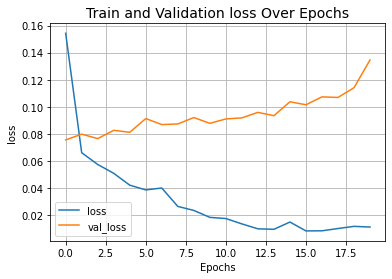

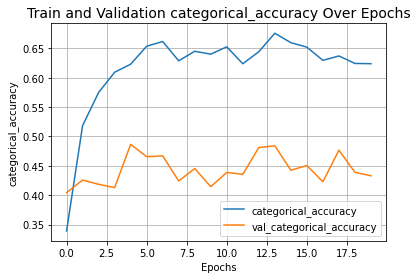

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

30/30 [==============================] - 3s 78ms/step - loss: 0.1033 - categorical_accuracy: 0.4489
Categorical accuracy on the test set: 44.89%.


In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Text: b'e written question p by ian hudghton verts ale to the commission french ban on imports of british beef official journal e p written question p by ian hudghton verts ale to the commission april subject french ban on imports of british beef in view of the european court of justice ruling in september that france has failed to fulfil its community obligations by continuing its ban on imports of british beef and given the commercial losses being sustained by british producers as a result of this unilateral action would the commission please inform members what action it has taken thus far to lift the ban given the ruling of the court of justice was given some six months ago what reparation will be made to british beef producers in order to compensate for the illegal actions of the french answer given by mr byrne on behalf of the commission april the judgement of the european court of justice in case c commission v french republic was dated december soon after the judgement the comm